In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import json
import tqdm
import dill
import pickle
import matplotlib.pyplot as plt

import scipy.stats
import cv2

import src.data
import src.metrics
import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.data.preprocessing
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.nn
import sak.torch.train
import sak.torch.data
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

# Raw

In [11]:
results_P_single   = {}
results_QRS_single = {}
results_T_single   = {}

for path in tqdm.tqdm(glob.glob('/home/guille/DADES/DADES/Delineator/TrainedModels/*/metrics_string.txt')):
    mname = os.path.split(os.path.split(path)[0])[1]
    with open(path, 'r') as f:
        res = f.read().splitlines()
        
    results_P_single[mname] = {
        "Precision": float(res[7].split(':')[1][:-1]),
        "Recall": float(res[8].split(':')[1][:-1]),
        "F1 Score": float(res[9].split(':')[1][:-1]),
        "Onset Error (mean)": float(res[11].split(':')[1][:-3].split("±")[0]),
        "Onset Error (std)": float(res[11].split(':')[1][:-3].split("±")[1]),
        "Offset Error (mean)": float(res[12].split(':')[1][:-3].split("±")[0]),
        "Offset Error (std)": float(res[12].split(':')[1][:-3].split("±")[1]),
    }

    results_QRS_single[mname] = {
        "Precision": float(res[17].split(':')[1][:-1]),
        "Recall": float(res[18].split(':')[1][:-1]),
        "F1 Score": float(res[19].split(':')[1][:-1]),
        "Onset Error (mean)": float(res[21].split(':')[1][:-3].split("±")[0]),
        "Onset Error (std)": float(res[21].split(':')[1][:-3].split("±")[1]),
        "Offset Error (mean)": float(res[22].split(':')[1][:-3].split("±")[0]),
        "Offset Error (std)": float(res[22].split(':')[1][:-3].split("±")[1]),
    }
    
    results_T_single[mname] = {
        "Precision": float(res[27].split(':')[1][:-1]),
        "Recall": float(res[28].split(':')[1][:-1]),
        "F1 Score": float(res[29].split(':')[1][:-1]),
        "Onset Error (mean)": float(res[31].split(':')[1][:-3].split("±")[0]),
        "Onset Error (std)": float(res[31].split(':')[1][:-3].split("±")[1]),
        "Offset Error (mean)": float(res[32].split(':')[1][:-3].split("±")[0]),
        "Offset Error (std)": float(res[32].split(':')[1][:-3].split("±")[1]),
    }

results_P_single = pd.DataFrame(results_P_single).T
results_QRS_single = pd.DataFrame(results_QRS_single).T
results_T_single = pd.DataFrame(results_T_single).T


100%|██████████| 66/66 [00:00<00:00, 7705.18it/s]


In [12]:
wave = 'P'
print(eval(f"results_{wave}_single").T['WNet5LevelsSelfAttentionConvDiceOnly_real_20201203231939'])
print("")
print(eval(f"results_{wave}_single").T['WNet5LevelsSelfAttention_synth_20201206012731'])

Precision              97.18
Recall                 96.31
F1 Score               96.74
Onset Error (mean)     -0.29
Onset Error (std)      20.20
Offset Error (mean)     3.52
Offset Error (std)     17.07
Name: WNet5LevelsSelfAttentionConvDiceOnly_real_20201203231939, dtype: float64

Precision              98.74
Recall                 94.65
F1 Score               96.65
Onset Error (mean)     -1.73
Onset Error (std)      18.33
Offset Error (mean)     4.05
Offset Error (std)     15.69
Name: WNet5LevelsSelfAttention_synth_20201206012731, dtype: float64


In [13]:
best = ((results_P_single['F1 Score']+results_QRS_single['F1 Score']+results_T_single['F1 Score'])/3).argmax()
print(results_P_single.T[list(results_P_single.T)[best]])
print("")
print(results_QRS_single.T[list(results_QRS_single.T)[best]])
print("")
print(results_T_single.T[list(results_T_single.T)[best]])

Precision              99.27
Recall                 98.38
F1 Score               98.82
Onset Error (mean)     -1.18
Onset Error (std)      17.93
Offset Error (mean)     1.10
Offset Error (std)     16.58
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64

Precision              99.31
Recall                 99.94
F1 Score               99.62
Onset Error (mean)     -0.53
Onset Error (std)      11.24
Offset Error (mean)     3.74
Offset Error (std)     13.05
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64

Precision              98.73
Recall                 99.78
F1 Score               99.25
Onset Error (mean)      5.80
Onset Error (std)      39.56
Offset Error (mean)     2.35
Offset Error (std)     51.27
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64


In [14]:
best = (
    (
        np.abs(results_P_single['Onset Error (std)'])+
        np.abs(results_P_single['Offset Error (std)'])+
        np.abs(results_QRS_single['Onset Error (std)'])+
        np.abs(results_QRS_single['Offset Error (std)'])+
        np.abs(results_T_single['Onset Error (std)'])+
        np.abs(results_T_single['Offset Error (std)'])
    )/6
).argmin()
print(results_P_single.T[list(results_P_single.T)[best]])
print("")
print(results_QRS_single.T[list(results_QRS_single.T)[best]])
print("")
print(results_T_single.T[list(results_T_single.T)[best]])

Precision              98.93
Recall                 97.34
F1 Score               98.13
Onset Error (mean)     -1.23
Onset Error (std)      18.44
Offset Error (mean)     1.45
Offset Error (std)     15.15
Name: UNet7LevelsConvDiceOnly_20201203124825, dtype: float64

Precision              99.60
Recall                 99.89
F1 Score               99.74
Onset Error (mean)     -1.08
Onset Error (std)      11.07
Offset Error (mean)     5.18
Offset Error (std)     13.80
Name: UNet7LevelsConvDiceOnly_20201203124825, dtype: float64

Precision              99.43
Recall                 99.78
F1 Score               99.60
Onset Error (mean)      3.76
Onset Error (std)      38.62
Offset Error (mean)     3.85
Offset Error (std)     48.37
Name: UNet7LevelsConvDiceOnly_20201203124825, dtype: float64


# Multi-lead

In [24]:
results_P_multi   = {}
results_QRS_multi = {}
results_T_multi   = {}

for path in tqdm.tqdm(glob.glob('/home/guille/DADES/DADES/Delineator/TrainedModels/*/metrics_string.txt')):
    mname = os.path.split(os.path.split(path)[0])[1]
    with open(path, 'r') as f:
        res = f.read().splitlines()
        
    results_P_multi[mname] = {
        "Precision": float(res[41].split(':')[1][:-1]),
        "Recall": float(res[42].split(':')[1][:-1]),
        "F1 Score": float(res[43].split(':')[1][:-1]),
        "Onset Error (mean)": float(res[45].split(':')[1][:-3].split("±")[0]),
        "Onset Error (std)": float(res[45].split(':')[1][:-3].split("±")[1]),
        "Offset Error (mean)": float(res[46].split(':')[1][:-3].split("±")[0]),
        "Offset Error (std)": float(res[46].split(':')[1][:-3].split("±")[1]),
    }

    results_QRS_multi[mname] = {
        "Precision": float(res[51].split(':')[1][:-1]),
        "Recall": float(res[52].split(':')[1][:-1]),
        "F1 Score": float(res[53].split(':')[1][:-1]),
        "Onset Error (mean)": float(res[55].split(':')[1][:-3].split("±")[0]),
        "Onset Error (std)": float(res[55].split(':')[1][:-3].split("±")[1]),
        "Offset Error (mean)": float(res[56].split(':')[1][:-3].split("±")[0]),
        "Offset Error (std)": float(res[56].split(':')[1][:-3].split("±")[1]),
    }
    
    results_T_multi[mname] = {
        "Precision": float(res[61].split(':')[1][:-1]),
        "Recall": float(res[62].split(':')[1][:-1]),
        "F1 Score": float(res[63].split(':')[1][:-1]),
        "Onset Error (mean)": float(res[65].split(':')[1][:-3].split("±")[0]),
        "Onset Error (std)": float(res[65].split(':')[1][:-3].split("±")[1]),
        "Offset Error (mean)": float(res[66].split(':')[1][:-3].split("±")[0]),
        "Offset Error (std)": float(res[66].split(':')[1][:-3].split("±")[1]),
    }

results_P_multi = pd.DataFrame(results_P_multi).T
results_QRS_multi = pd.DataFrame(results_QRS_multi).T
results_T_multi = pd.DataFrame(results_T_multi).T


100%|██████████| 66/66 [00:00<00:00, 5596.81it/s]


In [25]:
best = results_P_multi['Recall'].argmax()
print(results_P_multi.T[list(results_P_multi.T)[best]])
print("")
print(results_QRS_multi.T[list(results_QRS_multi.T)[best]])
print("")
print(results_T_multi.T[list(results_T_multi.T)[best]])

Precision              98.90
Recall                 99.72
F1 Score               99.31
Onset Error (mean)     -0.84
Onset Error (std)      13.54
Offset Error (mean)    -0.57
Offset Error (std)     12.71
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64

Precision              99.24
Recall                 99.97
F1 Score               99.60
Onset Error (mean)      0.06
Onset Error (std)       7.59
Offset Error (mean)     1.67
Offset Error (std)      7.81
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64

Precision              98.24
Recall                 99.97
F1 Score               99.10
Onset Error (mean)      5.21
Onset Error (std)      31.11
Offset Error (mean)     3.79
Offset Error (std)     37.18
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64


In [28]:
best = ((results_P_multi['F1 Score']+results_QRS_multi['F1 Score']+results_T_multi['F1 Score'])/3).argmax()
print(results_P_multi.T[list(results_P_multi.T)[best]])
print("")
print(results_QRS_multi.T[list(results_QRS_multi.T)[best]])
print("")
print(results_T_multi.T[list(results_T_multi.T)[best]])

Precision              98.90
Recall                 99.72
F1 Score               99.31
Onset Error (mean)     -0.84
Onset Error (std)      13.54
Offset Error (mean)    -0.57
Offset Error (std)     12.71
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64

Precision              99.24
Recall                 99.97
F1 Score               99.60
Onset Error (mean)      0.06
Onset Error (std)       7.59
Offset Error (mean)     1.67
Offset Error (std)      7.81
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64

Precision              98.24
Recall                 99.97
F1 Score               99.10
Onset Error (mean)      5.21
Onset Error (std)      31.11
Offset Error (mean)     3.79
Offset Error (std)     37.18
Name: WNet5LevelsSelfAttentionDiceOnly_20201130125349, dtype: float64


In [29]:
best = (
    (
        np.abs(results_P_multi['Onset Error (std)'])+
        np.abs(results_P_multi['Offset Error (std)'])+
        np.abs(results_QRS_multi['Onset Error (std)'])+
        np.abs(results_QRS_multi['Offset Error (std)'])+
        np.abs(results_T_multi['Onset Error (std)'])+
        np.abs(results_T_multi['Offset Error (std)'])
    )/6
).argmin()
print(results_P_multi.T[list(results_P_multi.T)[best]])
print("")
print(results_QRS_multi.T[list(results_QRS_multi.T)[best]])
print("")
print(results_T_multi.T[list(results_T_multi.T)[best]])

Precision              98.58
Recall                 98.45
F1 Score               98.52
Onset Error (mean)     -0.80
Onset Error (std)      12.65
Offset Error (mean)     0.08
Offset Error (std)     10.03
Name: UNet7LevelsConvDiceOnly_20201203124825, dtype: float64

Precision              99.52
Recall                 99.94
F1 Score               99.73
Onset Error (mean)     -0.42
Onset Error (std)       7.32
Offset Error (mean)     2.52
Offset Error (std)      8.45
Name: UNet7LevelsConvDiceOnly_20201203124825, dtype: float64

Precision              99.11
Recall                 99.94
F1 Score               99.52
Onset Error (mean)      3.84
Onset Error (std)      30.74
Offset Error (mean)     4.25
Offset Error (std)     35.53
Name: UNet7LevelsConvDiceOnly_20201203124825, dtype: float64


# Real vs synthetic vs Real+Synthetic

In [123]:
results_P_real_single = pd.DataFrame({k.split("_")[0]: results_P_single.T[k].to_dict() for k in results_P_single.T if "_real_" in k}).T
results_P_synth_single = pd.DataFrame({k.split("_")[0]: results_P_single.T[k].to_dict() for k in results_P_single.T if "_synth_" in k}).T
results_P_all_single = pd.DataFrame({k.split("_")[0]: results_P_single.T[k].to_dict() for k in results_P_single.T if (("_real_" not in k) and ("_synth_" not in k))}).T
results_P_real_multi = pd.DataFrame({k.split("_")[0]: results_P_multi.T[k].to_dict() for k in results_P_multi.T if "_real_" in k}).T
results_P_synth_multi = pd.DataFrame({k.split("_")[0]: results_P_multi.T[k].to_dict() for k in results_P_multi.T if "_synth_" in k}).T
results_P_all_multi = pd.DataFrame({k.split("_")[0]: results_P_multi.T[k].to_dict() for k in results_P_multi.T if (("_real_" not in k) and ("_synth_" not in k))}).T

results_QRS_real_single = pd.DataFrame({k.split("_")[0]: results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "_real_" in k}).T
results_QRS_synth_single = pd.DataFrame({k.split("_")[0]: results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "_synth_" in k}).T
results_QRS_all_single = pd.DataFrame({k.split("_")[0]: results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if (("_real_" not in k) and ("_synth_" not in k))}).T
results_QRS_real_multi = pd.DataFrame({k.split("_")[0]: results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "_real_" in k}).T
results_QRS_synth_multi = pd.DataFrame({k.split("_")[0]: results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "_synth_" in k}).T
results_QRS_all_multi = pd.DataFrame({k.split("_")[0]: results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if (("_real_" not in k) and ("_synth_" not in k))}).T

results_T_real_single = pd.DataFrame({k.split("_")[0]: results_T_single.T[k].to_dict() for k in results_T_single.T if "_real_" in k}).T
results_T_synth_single = pd.DataFrame({k.split("_")[0]: results_T_single.T[k].to_dict() for k in results_T_single.T if "_synth_" in k}).T
results_T_all_single = pd.DataFrame({k.split("_")[0]: results_T_single.T[k].to_dict() for k in results_T_single.T if (("_real_" not in k) and ("_synth_" not in k))}).T
results_T_real_multi = pd.DataFrame({k.split("_")[0]: results_T_multi.T[k].to_dict() for k in results_T_multi.T if "_real_" in k}).T
results_T_synth_multi = pd.DataFrame({k.split("_")[0]: results_T_multi.T[k].to_dict() for k in results_T_multi.T if "_synth_" in k}).T
results_T_all_multi = pd.DataFrame({k.split("_")[0]: results_T_multi.T[k].to_dict() for k in results_T_multi.T if (("_real_" not in k) and ("_synth_" not in k))}).T

In [136]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    real = eval(f"results_{wave}_real_single")
    synth = eval(f"results_{wave}_synth_single")
    allres = eval(f"results_{wave}_all_single")

    for m in ["Precision","Recall","On", "Off"]:
        print(f"### {m} ###")
        if m in ["On", "Off"]:
            print(f"Synth -  Real: {np.round(np.median(synth[f'{m}set Error (mean)']-real[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(synth[f'{m}set Error (std)']-real[f'{m}set Error (std)']),2)}") # ± {np.std(synth[m]-real[m])}")
            print(f"All   -  Real: {np.round(np.median(allres[f'{m}set Error (mean)']-real[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(allres[f'{m}set Error (std)']-real[f'{m}set Error (std)']),2)}") # ± {np.std(allres[m]-real[m])}")
            print(f"All   - Synth: {np.round(np.median(allres[f'{m}set Error (mean)']-synth[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(allres[f'{m}set Error (std)']-synth[f'{m}set Error (std)']),2)}") # ± {np.std(allres[m]-synth[m])}")
        else:
            print(f"Synth -  Real: {np.round(np.median(synth[m]-real[m]),2)}") # ± {np.std(synth[m]-real[m])}")
            print(f"All   -  Real: {np.round(np.median(allres[m]-real[m]),2)}") # ± {np.std(allres[m]-real[m])}")
            print(f"All   - Synth: {np.round(np.median(allres[m]-synth[m]),2)}") # ± {np.std(allres[m]-synth[m])}")
        print("")

############## P wave ##############
### Precision ###
Synth -  Real: 0.51
All   -  Real: 0.65
All   - Synth: 0.25

### Recall ###
Synth -  Real: 0.91
All   -  Real: 1.85
All   - Synth: 0.76

### On ###
Synth -  Real: -3.9$\pm$0.25
All   -  Real: -1.81$\pm$-0.99
All   - Synth: 2.01$\pm$-1.04

### Off ###
Synth -  Real: -2.3$\pm$-0.57
All   -  Real: -1.35$\pm$-1.19
All   - Synth: 0.94$\pm$-0.8

############## QRS wave ##############
### Precision ###
Synth -  Real: 0.49
All   -  Real: 0.41
All   - Synth: -0.03

### Recall ###
Synth -  Real: -0.02
All   -  Real: 0.0
All   - Synth: 0.0

### On ###
Synth -  Real: -2.04$\pm$-0.75
All   -  Real: -0.95$\pm$-0.99
All   - Synth: 1.01$\pm$-0.27

### Off ###
Synth -  Real: 1.22$\pm$-0.86
All   -  Real: 0.4$\pm$-2.42
All   - Synth: -0.58$\pm$-1.17

############## T wave ##############
### Precision ###
Synth -  Real: 0.72
All   -  Real: 1.25
All   - Synth: -0.02

### Recall ###
Synth -  Real: -0.21
All   -  Real: -0.12
All   - Synth: 0.13

### On 

In [137]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    real = eval(f"results_{wave}_real_multi")
    synth = eval(f"results_{wave}_synth_multi")
    allres = eval(f"results_{wave}_all_multi")

    for m in ["Precision","Recall","On", "Off"]:
        print(f"### {m} ###")
        if m in ["On", "Off"]:
            print(f"Synth -  Real: {np.round(np.median(synth[f'{m}set Error (mean)']-real[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(synth[f'{m}set Error (std)']-real[f'{m}set Error (std)']),2)}") # ± {np.std(synth[m]-real[m])}")
            print(f"All   -  Real: {np.round(np.median(allres[f'{m}set Error (mean)']-real[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(allres[f'{m}set Error (std)']-real[f'{m}set Error (std)']),2)}") # ± {np.std(allres[m]-real[m])}")
            print(f"All   - Synth: {np.round(np.median(allres[f'{m}set Error (mean)']-synth[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(allres[f'{m}set Error (std)']-synth[f'{m}set Error (std)']),2)}") # ± {np.std(allres[m]-synth[m])}")
        else:
            print(f"Synth -  Real: {np.round(np.median(synth[m]-real[m]),2)}") # ± {np.std(synth[m]-real[m])}")
            print(f"All   -  Real: {np.round(np.median(allres[m]-real[m]),2)}") # ± {np.std(allres[m]-real[m])}")
            print(f"All   - Synth: {np.round(np.median(allres[m]-synth[m]),2)}") # ± {np.std(allres[m]-synth[m])}")
        print("")

############## P wave ##############
### Precision ###
Synth -  Real: 0.56
All   -  Real: 1.27
All   - Synth: 0.39

### Recall ###
Synth -  Real: -0.19
All   -  Real: 0.38
All   - Synth: 0.38

### On ###
Synth -  Real: -2.12$\pm$0.74
All   -  Real: -1.08$\pm$-0.08
All   - Synth: 1.46$\pm$-0.8

### Off ###
Synth -  Real: -2.01$\pm$-1.13
All   -  Real: -1.23$\pm$-1.76
All   - Synth: 0.62$\pm$-0.6

############## QRS wave ##############
### Precision ###
Synth -  Real: 0.08
All   -  Real: -0.19
All   - Synth: -0.17

### Recall ###
Synth -  Real: 0.0
All   -  Real: 0.0
All   - Synth: 0.0

### On ###
Synth -  Real: -1.27$\pm$0.02
All   -  Real: -0.68$\pm$-0.16
All   - Synth: 0.75$\pm$-0.21

### Off ###
Synth -  Real: -0.07$\pm$-1.41
All   -  Real: -0.53$\pm$-2.21
All   - Synth: -0.18$\pm$-0.99

############## T wave ##############
### Precision ###
Synth -  Real: 1.13
All   -  Real: 1.27
All   - Synth: 0.09

### Recall ###
Synth -  Real: -0.16
All   -  Real: -0.1
All   - Synth: 0.08

### On

# U-Net vs W-Net

In [152]:
results_P_UNet_single = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_P_single.T[k].to_dict() for k in results_P_single.T if "UNet" in k}).T
results_P_WNet_single = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_P_single.T[k].to_dict() for k in results_P_single.T if "WNet" in k}).T
results_P_UNet_multi = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_P_multi.T[k].to_dict() for k in results_P_multi.T if "UNet" in k}).T
results_P_WNet_multi = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_P_multi.T[k].to_dict() for k in results_P_multi.T if "WNet" in k}).T

results_QRS_UNet_single = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "UNet" in k}).T
results_QRS_WNet_single = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "WNet" in k}).T
results_QRS_UNet_multi = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "UNet" in k}).T
results_QRS_WNet_multi = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "WNet" in k}).T

results_T_UNet_single = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_T_single.T[k].to_dict() for k in results_T_single.T if "UNet" in k}).T
results_T_WNet_single = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_T_single.T[k].to_dict() for k in results_T_single.T if "WNet" in k}).T
results_T_UNet_multi = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_T_multi.T[k].to_dict() for k in results_T_multi.T if "UNet" in k}).T
results_T_WNet_multi = pd.DataFrame({"_".join(k.split("_")[:-1])[4:]: results_T_multi.T[k].to_dict() for k in results_T_multi.T if "WNet" in k}).T

In [153]:
filt = np.array(list(results_P_UNet_single.T))[:,None] == np.array(list(results_P_WNet_single.T))
filt_names = np.array(list(results_P_UNet_single.T))[np.argwhere(filt)[:,0]]

results_P_UNet_single = results_P_UNet_single.T[filt_names].T
results_P_WNet_single = results_P_WNet_single.T[filt_names].T
results_QRS_UNet_single = results_QRS_UNet_single.T[filt_names].T
results_QRS_WNet_single = results_QRS_WNet_single.T[filt_names].T
results_T_UNet_single = results_T_UNet_single.T[filt_names].T
results_T_WNet_single = results_T_WNet_single.T[filt_names].T
results_P_UNet_multi = results_P_UNet_multi.T[filt_names].T
results_P_WNet_multi = results_P_WNet_multi.T[filt_names].T
results_QRS_UNet_multi = results_QRS_UNet_multi.T[filt_names].T
results_QRS_WNet_multi = results_QRS_WNet_multi.T[filt_names].T
results_T_UNet_multi = results_T_UNet_multi.T[filt_names].T
results_T_WNet_multi = results_T_WNet_multi.T[filt_names].T

In [154]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    wnet = eval(f"results_{wave}_WNet_single")
    unet = eval(f"results_{wave}_UNet_single")

    for m in ["Precision","Recall","On", "Off"]:
        if m in ["On", "Off"]:
            print(f"### {m[:2]} ###    WNet - UNet: {np.round(np.median(wnet[f'{m}set Error (mean)']-unet[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(wnet[f'{m}set Error (std)']-unet[f'{m}set Error (std)']),2)}")
        else:
            print(f"### {m[:2]} ###    WNet - UNet: {np.round(np.median(wnet[m]-unet[m]),2)}")
    print("")

############## P wave ##############
### Pr ###    WNet - UNet: 0.31
### Re ###    WNet - UNet: -0.46
### On ###    WNet - UNet: -0.2$\pm$0.59
### Of ###    WNet - UNet: -0.0$\pm$0.29

############## QRS wave ##############
### Pr ###    WNet - UNet: 0.22
### Re ###    WNet - UNet: 0.02
### On ###    WNet - UNet: -0.02$\pm$0.1
### Of ###    WNet - UNet: -0.01$\pm$-0.63

############## T wave ##############
### Pr ###    WNet - UNet: 1.93
### Re ###    WNet - UNet: 0.09
### On ###    WNet - UNet: 2.43$\pm$1.77
### Of ###    WNet - UNet: -2.93$\pm$0.86



In [155]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    wnet = eval(f"results_{wave}_WNet_multi")
    unet = eval(f"results_{wave}_UNet_multi")

    for m in ["Precision","Recall","On", "Off"]:
        if m in ["On", "Off"]:
            print(f"### {m[:2]} ###    WNet - UNet: {np.round(np.median(wnet[f'{m}set Error (mean)']-unet[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(wnet[f'{m}set Error (std)']-unet[f'{m}set Error (std)']),2)}") # ± {np.std(synth[m]-real[m])}")
        else:
            print(f"### {m[:2]} ###    WNet - UNet: {np.round(np.median(wnet[m]-unet[m]),2)}") # ± {np.std(synth[m]-real[m])}")
    print("")

############## P wave ##############
### Pr ###    WNet - UNet: 0.4
### Re ###    WNet - UNet: -0.12
### On ###    WNet - UNet: -0.27$\pm$0.48
### Of ###    WNet - UNet: -0.04$\pm$0.33

############## QRS wave ##############
### Pr ###    WNet - UNet: 0.29
### Re ###    WNet - UNet: 0.0
### On ###    WNet - UNet: -0.08$\pm$0.0
### Of ###    WNet - UNet: -0.17$\pm$-0.58

############## T wave ##############
### Pr ###    WNet - UNet: 2.33
### Re ###    WNet - UNet: 0.05
### On ###    WNet - UNet: 1.95$\pm$2.0
### Of ###    WNet - UNet: -1.18$\pm$0.08



# Dice vs F1

In [176]:
results_P_Dice_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_P_single.T[k].to_dict() for k in results_P_single.T if "DiceOnly" in k}).T
results_P_F1_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_P_single.T[k].to_dict() for k in results_P_single.T if not ("DiceOnly" in k)}).T
results_P_Dice_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_P_multi.T[k].to_dict() for k in results_P_multi.T if "DiceOnly" in k}).T
results_P_F1_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_P_multi.T[k].to_dict() for k in results_P_multi.T if not ("DiceOnly" in k)}).T

results_QRS_Dice_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "DiceOnly" in k}).T
results_QRS_F1_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if not ("DiceOnly" in k)}).T
results_QRS_Dice_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "DiceOnly" in k}).T
results_QRS_F1_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if not ("DiceOnly" in k)}).T

results_T_Dice_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_T_single.T[k].to_dict() for k in results_T_single.T if "DiceOnly" in k}).T
results_T_F1_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_T_single.T[k].to_dict() for k in results_T_single.T if not ("DiceOnly" in k)}).T
results_T_Dice_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_T_multi.T[k].to_dict() for k in results_T_multi.T if "DiceOnly" in k}).T
results_T_F1_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("DiceOnly",""): results_T_multi.T[k].to_dict() for k in results_T_multi.T if not ("DiceOnly" in k)}).T

In [177]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    f1 = eval(f"results_{wave}_F1_single")
    dice = eval(f"results_{wave}_Dice_single")

    for m in ["Precision","Recall","On", "Off"]:
        if m in ["On", "Off"]:
            print(f"### {m[:2]} ###    F1 - Dice: {np.round(np.median(f1[f'{m}set Error (mean)']-dice[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(f1[f'{m}set Error (std)']-dice[f'{m}set Error (std)']),2)}")
        else:
            print(f"### {m[:2]} ###    F1 - Dice: {np.round(np.median(f1[m]-dice[m]),2)}")
    print("")

############## P wave ##############
### Pr ###    F1 - Dice: 0.0
### Re ###    F1 - Dice: -0.41
### On ###    F1 - Dice: -1.69$\pm$-0.12
### Of ###    F1 - Dice: 1.15$\pm$-0.41

############## QRS wave ##############
### Pr ###    F1 - Dice: 0.02
### Re ###    F1 - Dice: 0.02
### On ###    F1 - Dice: -0.87$\pm$0.21
### Of ###    F1 - Dice: 1.03$\pm$0.44

############## T wave ##############
### Pr ###    F1 - Dice: 0.72
### Re ###    F1 - Dice: -0.04
### On ###    F1 - Dice: -7.56$\pm$0.07
### Of ###    F1 - Dice: 8.42$\pm$-1.0



In [179]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    f1 = eval(f"results_{wave}_F1_multi")
    dice = eval(f"results_{wave}_Dice_multi")

    for m in ["Precision","Recall","On", "Off"]:
        if m in ["On", "Off"]:
            print(f"### {m[:2]} ###    F1 - Dice: {np.round(np.median(f1[f'{m}set Error (mean)']-dice[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(f1[f'{m}set Error (std)']-dice[f'{m}set Error (std)']),2)}")
        else:
            print(f"### {m[:2]} ###    F1 - Dice: {np.round(np.median(f1[m]-dice[m]),2)}")
    print("")

############## P wave ##############
### Pr ###    F1 - Dice: -0.13
### Re ###    F1 - Dice: -0.48
### On ###    F1 - Dice: -1.07$\pm$-0.07
### Of ###    F1 - Dice: 0.69$\pm$-0.29

############## QRS wave ##############
### Pr ###    F1 - Dice: 0.0
### Re ###    F1 - Dice: 0.03
### On ###    F1 - Dice: -0.54$\pm$0.17
### Of ###    F1 - Dice: 0.59$\pm$0.1

############## T wave ##############
### Pr ###    F1 - Dice: 1.12
### Re ###    F1 - Dice: -0.03
### On ###    F1 - Dice: -4.79$\pm$0.14
### Of ###    F1 - Dice: 5.78$\pm$0.35



# SelfAttention vs Not

In [180]:
results_P_Self_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_P_single.T[k].to_dict() for k in results_P_single.T if "SelfAttention" in k}).T
results_P_NotSelf_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_P_single.T[k].to_dict() for k in results_P_single.T if not ("SelfAttention" in k)}).T
results_P_Self_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_P_multi.T[k].to_dict() for k in results_P_multi.T if "SelfAttention" in k}).T
results_P_NotSelf_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_P_multi.T[k].to_dict() for k in results_P_multi.T if not ("SelfAttention" in k)}).T

results_QRS_Self_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "SelfAttention" in k}).T
results_QRS_NotSelf_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if not ("SelfAttention" in k)}).T
results_QRS_Self_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "SelfAttention" in k}).T
results_QRS_NotSelf_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if not ("SelfAttention" in k)}).T

results_T_Self_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_T_single.T[k].to_dict() for k in results_T_single.T if "SelfAttention" in k}).T
results_T_NotSelf_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_T_single.T[k].to_dict() for k in results_T_single.T if not ("SelfAttention" in k)}).T
results_T_Self_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_T_multi.T[k].to_dict() for k in results_T_multi.T if "SelfAttention" in k}).T
results_T_NotSelf_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("SelfAttention",""): results_T_multi.T[k].to_dict() for k in results_T_multi.T if not ("SelfAttention" in k)}).T

In [181]:
filt = np.array(list(results_P_Self_single.T))[:,None] == np.array(list(results_P_NotSelf_single.T))
filt_names = np.array(list(results_P_Self_single.T))[np.argwhere(filt)[:,0]]

results_P_Self_single = results_P_Self_single.T[filt_names].T
results_P_NotSelf_single = results_P_NotSelf_single.T[filt_names].T
results_QRS_Self_single = results_QRS_Self_single.T[filt_names].T
results_QRS_NotSelf_single = results_QRS_NotSelf_single.T[filt_names].T
results_T_Self_single = results_T_Self_single.T[filt_names].T
results_T_NotSelf_single = results_T_NotSelf_single.T[filt_names].T
results_P_Self_multi = results_P_Self_multi.T[filt_names].T
results_P_NotSelf_multi = results_P_NotSelf_multi.T[filt_names].T
results_QRS_Self_multi = results_QRS_Self_multi.T[filt_names].T
results_QRS_NotSelf_multi = results_QRS_NotSelf_multi.T[filt_names].T
results_T_Self_multi = results_T_Self_multi.T[filt_names].T
results_T_NotSelf_multi = results_T_NotSelf_multi.T[filt_names].T

In [182]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    Self = eval(f"results_{wave}_Self_single")
    NotSelf = eval(f"results_{wave}_NotSelf_single")

    for m in ["Precision","Recall","On", "Off"]:
        if m in ["On", "Off"]:
            print(f"### {m[:2]} ###    Attention - Not: {np.round(np.median(Self[f'{m}set Error (mean)']-NotSelf[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(Self[f'{m}set Error (std)']-NotSelf[f'{m}set Error (std)']),2)}")
        else:
            print(f"### {m[:2]} ###    Attention - Not: {np.round(np.median(Self[m]-NotSelf[m]),2)}")
    print("")

############## P wave ##############
### Pr ###    Attention - Not: -0.11
### Re ###    Attention - Not: 1.41
### On ###    Attention - Not: 3.18$\pm$-1.48
### Of ###    Attention - Not: 0.7$\pm$-0.15

############## QRS wave ##############
### Pr ###    Attention - Not: -0.38
### Re ###    Attention - Not: 0.04
### On ###    Attention - Not: 1.06$\pm$-0.41
### Of ###    Attention - Not: -1.61$\pm$-1.0

############## T wave ##############
### Pr ###    Attention - Not: -0.04
### Re ###    Attention - Not: 0.23
### On ###    Attention - Not: 0.07$\pm$-3.1
### Of ###    Attention - Not: -0.57$\pm$-4.39



In [183]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    Self = eval(f"results_{wave}_Self_multi")
    NotSelf = eval(f"results_{wave}_NotSelf_multi")

    for m in ["Precision","Recall","On", "Off"]:
        if m in ["On", "Off"]:
            print(f"### {m[:2]} ###    Attention - Not: {np.round(np.median(Self[f'{m}set Error (mean)']-NotSelf[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(Self[f'{m}set Error (std)']-NotSelf[f'{m}set Error (std)']),2)}")
        else:
            print(f"### {m[:2]} ###    Attention - Not: {np.round(np.median(Self[m]-NotSelf[m]),2)}")
    print("")

############## P wave ##############
### Pr ###    Attention - Not: 0.04
### Re ###    Attention - Not: 0.76
### On ###    Attention - Not: 2.06$\pm$-2.15
### Of ###    Attention - Not: 0.49$\pm$-0.12

############## QRS wave ##############
### Pr ###    Attention - Not: -0.3
### Re ###    Attention - Not: 0.05
### On ###    Attention - Not: 0.8$\pm$-0.07
### Of ###    Attention - Not: -0.93$\pm$-0.59

############## T wave ##############
### Pr ###    Attention - Not: -0.03
### Re ###    Attention - Not: 0.16
### On ###    Attention - Not: 1.1$\pm$-3.66
### Of ###    Attention - Not: -0.28$\pm$-5.5



# Levels

In [184]:
results_P_single.T.keys()

Index(['WNet5LevelsConvDiceOnly_20201130125349',
       'WNet5LevelsConvDiceOnly_real_20201204020927',
       'WNet5LevelsConvDiceOnly_synth_20201210195924',
       'WNet5LevelsConv_20201124143432', 'WNet5LevelsConv_real_20201128064651',
       'WNet5LevelsConv_synth_20201206145918',
       'WNet5LevelsDiceOnly_20201130125349',
       'WNet5LevelsDiceOnly_real_20201203185909',
       'WNet5LevelsDiceOnly_synth_20201209185735',
       'WNet5LevelsSelfAttentionConvDiceOnly_20201130125349',
       'WNet5LevelsSelfAttentionConvDiceOnly_real_20201203231939',
       'WNet5LevelsSelfAttentionConvDiceOnly_synth_20201210041533',
       'WNet5LevelsSelfAttentionConv_20201124143433',
       'WNet5LevelsSelfAttentionConv_real_20201128033608',
       'UNet5LevelsConvDiceOnly_20201202003451',
       'UNet5LevelsConvDiceOnly_real_20201204204042',
       'UNet5LevelsConvDiceOnly_synth_20201211065325',
       'UNet7LevelsConvDiceOnly_20201203124825',
       'WNet5LevelsSelfAttentionConv_synth_202012060

In [185]:
results_P_5Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("5Levels",""): results_P_single.T[k].to_dict() for k in results_P_single.T if "5Levels" in k}).T
results_P_6Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("6Levels",""): results_P_single.T[k].to_dict() for k in results_P_single.T if "6Levels" in k}).T
results_P_7Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("7Levels",""): results_P_single.T[k].to_dict() for k in results_P_single.T if "7Levels" in k}).T
results_P_5Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("5Levels",""): results_P_multi.T[k].to_dict() for k in results_P_multi.T if "5Levels" in k}).T
results_P_6Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("6Levels",""): results_P_multi.T[k].to_dict() for k in results_P_multi.T if "6Levels" in k}).T
results_P_7Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("7Levels",""): results_P_multi.T[k].to_dict() for k in results_P_multi.T if "7Levels" in k}).T

results_QRS_5Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("5Levels",""): results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "5Levels" in k}).T
results_QRS_6Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("6Levels",""): results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "6Levels" in k}).T
results_QRS_7Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("7Levels",""): results_QRS_single.T[k].to_dict() for k in results_QRS_single.T if "7Levels" in k}).T
results_QRS_5Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("5Levels",""): results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "5Levels" in k}).T
results_QRS_6Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("6Levels",""): results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "6Levels" in k}).T
results_QRS_7Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("7Levels",""): results_QRS_multi.T[k].to_dict() for k in results_QRS_multi.T if "7Levels" in k}).T

results_T_5Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("5Levels",""): results_T_single.T[k].to_dict() for k in results_T_single.T if "5Levels" in k}).T
results_T_6Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("6Levels",""): results_T_single.T[k].to_dict() for k in results_T_single.T if "6Levels" in k}).T
results_T_7Levels_single = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("7Levels",""): results_T_single.T[k].to_dict() for k in results_T_single.T if "7Levels" in k}).T
results_T_5Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("5Levels",""): results_T_multi.T[k].to_dict() for k in results_T_multi.T if "5Levels" in k}).T
results_T_6Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("6Levels",""): results_T_multi.T[k].to_dict() for k in results_T_multi.T if "6Levels" in k}).T
results_T_7Levels_multi = pd.DataFrame({"_".join(k.split("_")[:-1]).replace("7Levels",""): results_T_multi.T[k].to_dict() for k in results_T_multi.T if "7Levels" in k}).T

In [196]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    lvl5 = eval(f"results_{wave}_5Levels_single")
    lvl6 = eval(f"results_{wave}_6Levels_single")
    lvl7 = eval(f"results_{wave}_7Levels_single")
    
    filt = np.array(list(lvl5.T))[:,None] == np.array(list(lvl6.T))
    filt_names = np.array(list(lvl5.T))[np.argwhere(filt)[:,0]]
    lvl65 = (lvl6.T[filt_names].T).copy()-(lvl5.T[filt_names].T).copy()

    filt = np.array(list(lvl5.T))[:,None] == np.array(list(lvl7.T))
    filt_names = np.array(list(lvl5.T))[np.argwhere(filt)[:,0]]
    lvl75 = (lvl7.T[filt_names].T).copy()-(lvl5.T[filt_names].T).copy()

    filt = np.array(list(lvl6.T))[:,None] == np.array(list(lvl7.T))
    filt_names = np.array(list(lvl6.T))[np.argwhere(filt)[:,0]]
    lvl76 = (lvl7.T[filt_names].T).copy()-(lvl6.T[filt_names].T).copy()

    for m in ["Precision","Recall","On", "Off"]:
        print(f"### {m} ###")
        if m in ["On", "Off"]:
            print(f"Lvl6 - Lvl5: {np.round(np.median(lvl65[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(lvl65[f'{m}set Error (std)']),2)}")
            print(f"Lvl7 - Lvl5: {np.round(np.median(lvl75[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(lvl75[f'{m}set Error (std)']),2)}")
            print(f"Lvl7 - Lvl6: {np.round(np.median(lvl76[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(lvl76[f'{m}set Error (std)']),2)}")
        else:
            print(f"Lvl6 - Lvl5: {np.round(np.median(lvl65[m]),2)}")
            print(f"Lvl7 - Lvl5: {np.round(np.median(lvl75[m]),2)}")
            print(f"Lvl7 - Lvl6: {np.round(np.median(lvl76[m]),2)}")
        print("")

############## P wave ##############
### Precision ###
Lvl6 - Lvl5: 0.12
Lvl7 - Lvl5: 0.18
Lvl7 - Lvl6: 0.1

### Recall ###
Lvl6 - Lvl5: 0.17
Lvl7 - Lvl5: -0.13
Lvl7 - Lvl6: 0.17

### On ###
Lvl6 - Lvl5: 0.72$\pm$0.01
Lvl7 - Lvl5: 1.04$\pm$0.7
Lvl7 - Lvl6: 0.45$\pm$0.4

### Off ###
Lvl6 - Lvl5: 0.26$\pm$-0.31
Lvl7 - Lvl5: 0.55$\pm$0.25
Lvl7 - Lvl6: -0.12$\pm$0.13

############## QRS wave ##############
### Precision ###
Lvl6 - Lvl5: 0.2
Lvl7 - Lvl5: 0.42
Lvl7 - Lvl6: 0.14

### Recall ###
Lvl6 - Lvl5: 0.03
Lvl7 - Lvl5: 0.0
Lvl7 - Lvl6: -0.02

### On ###
Lvl6 - Lvl5: 0.22$\pm$-0.06
Lvl7 - Lvl5: 0.33$\pm$0.11
Lvl7 - Lvl6: -0.13$\pm$-0.04

### Off ###
Lvl6 - Lvl5: -0.32$\pm$-1.26
Lvl7 - Lvl5: -0.68$\pm$-2.52
Lvl7 - Lvl6: -0.05$\pm$0.38

############## T wave ##############
### Precision ###
Lvl6 - Lvl5: 2.09
Lvl7 - Lvl5: 3.42
Lvl7 - Lvl6: 0.21

### Recall ###
Lvl6 - Lvl5: 0.23
Lvl7 - Lvl5: 0.58
Lvl7 - Lvl6: 0.04

### On ###
Lvl6 - Lvl5: 1.28$\pm$0.4
Lvl7 - Lvl5: 1.0$\pm$0.23
Lvl7 - Lvl6: -

In [197]:
for wave in ["P", "QRS", "T"]:
    print(f"############## {wave} wave ##############")

    lvl5 = eval(f"results_{wave}_5Levels_multi")
    lvl6 = eval(f"results_{wave}_6Levels_multi")
    lvl7 = eval(f"results_{wave}_7Levels_multi")
    
    filt = np.array(list(lvl5.T))[:,None] == np.array(list(lvl6.T))
    filt_names = np.array(list(lvl5.T))[np.argwhere(filt)[:,0]]
    lvl65 = (lvl6.T[filt_names].T).copy()-(lvl5.T[filt_names].T).copy()

    filt = np.array(list(lvl5.T))[:,None] == np.array(list(lvl7.T))
    filt_names = np.array(list(lvl5.T))[np.argwhere(filt)[:,0]]
    lvl75 = (lvl7.T[filt_names].T).copy()-(lvl5.T[filt_names].T).copy()

    filt = np.array(list(lvl6.T))[:,None] == np.array(list(lvl7.T))
    filt_names = np.array(list(lvl6.T))[np.argwhere(filt)[:,0]]
    lvl76 = (lvl7.T[filt_names].T).copy()-(lvl6.T[filt_names].T).copy()

    for m in ["Precision","Recall","On", "Off"]:
        print(f"### {m} ###")
        if m in ["On", "Off"]:
            print(f"Lvl6 - Lvl5: {np.round(np.median(lvl65[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(lvl65[f'{m}set Error (std)']),2)}")
            print(f"Lvl7 - Lvl5: {np.round(np.median(lvl75[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(lvl75[f'{m}set Error (std)']),2)}")
            print(f"Lvl7 - Lvl6: {np.round(np.median(lvl76[f'{m}set Error (mean)']),2)}$\pm${np.round(np.median(lvl76[f'{m}set Error (std)']),2)}")
        else:
            print(f"Lvl6 - Lvl5: {np.round(np.median(lvl65[m]),2)}")
            print(f"Lvl7 - Lvl5: {np.round(np.median(lvl75[m]),2)}")
            print(f"Lvl7 - Lvl6: {np.round(np.median(lvl76[m]),2)}")
        print("")

############## P wave ##############
### Precision ###
Lvl6 - Lvl5: 0.13
Lvl7 - Lvl5: 0.25
Lvl7 - Lvl6: 0.23

### Recall ###
Lvl6 - Lvl5: 0.46
Lvl7 - Lvl5: 0.33
Lvl7 - Lvl6: 0.19

### On ###
Lvl6 - Lvl5: 0.47$\pm$-0.06
Lvl7 - Lvl5: 0.79$\pm$0.22
Lvl7 - Lvl6: 0.4$\pm$0.09

### Off ###
Lvl6 - Lvl5: 0.24$\pm$-0.12
Lvl7 - Lvl5: 0.11$\pm$0.32
Lvl7 - Lvl6: -0.16$\pm$-0.0

############## QRS wave ##############
### Precision ###
Lvl6 - Lvl5: 0.05
Lvl7 - Lvl5: 0.52
Lvl7 - Lvl6: 0.2

### Recall ###
Lvl6 - Lvl5: 0.0
Lvl7 - Lvl5: -0.02
Lvl7 - Lvl6: 0.0

### On ###
Lvl6 - Lvl5: 0.07$\pm$0.04
Lvl7 - Lvl5: 0.08$\pm$0.32
Lvl7 - Lvl6: -0.19$\pm$0.25

### Off ###
Lvl6 - Lvl5: -0.17$\pm$-0.77
Lvl7 - Lvl5: -0.53$\pm$-2.42
Lvl7 - Lvl6: -0.01$\pm$0.37

############## T wave ##############
### Precision ###
Lvl6 - Lvl5: 2.69
Lvl7 - Lvl5: 3.68
Lvl7 - Lvl6: 0.33

### Recall ###
Lvl6 - Lvl5: 0.06
Lvl7 - Lvl5: 0.11
Lvl7 - Lvl6: 0.03

### On ###
Lvl6 - Lvl5: 1.84$\pm$1.14
Lvl7 - Lvl5: 1.56$\pm$0.73
Lvl7 - Lvl6: 

# Dice vs F1 - SINGLE

In [141]:
results_P_single_Dice   = {}
results_P_single_F1     = {}
results_QRS_single_Dice = {}
results_QRS_single_F1   = {}
results_T_single_Dice   = {}
results_T_single_F1     = {}

for path in tqdm.tqdm(glob.glob('/home/guille/DADES/DADES/Delineator/TrainedModels/*/metrics_string.txt')):
    full_mname = os.path.split(os.path.split(path)[0])[1]
    mname = "_".join(full_mname.replace("DiceOnly","").split("_")[:-1])
    
    with open(path, 'r') as f:
        res = f.read().splitlines()
    
    if "DiceOnly" in full_mname:
        results_P_single_Dice[mname] = {
            "Precision": float(res[7].split(':')[1][:-1]),
            "Recall": float(res[8].split(':')[1][:-1]),
            "F1 Score": float(res[9].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[11].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[11].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[12].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[12].split(':')[1][:-3].split("±")[1]),
        }

        results_QRS_single_Dice[mname] = {
            "Precision": float(res[17].split(':')[1][:-1]),
            "Recall": float(res[18].split(':')[1][:-1]),
            "F1 Score": float(res[19].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[21].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[21].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[22].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[22].split(':')[1][:-3].split("±")[1]),
        }

        results_T_single_Dice[mname] = {
            "Precision": float(res[27].split(':')[1][:-1]),
            "Recall": float(res[28].split(':')[1][:-1]),
            "F1 Score": float(res[29].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[31].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[31].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[32].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[32].split(':')[1][:-3].split("±")[1]),
        }
    else:
        results_P_single_F1[mname] = {
            "Precision": float(res[7].split(':')[1][:-1]),
            "Recall": float(res[8].split(':')[1][:-1]),
            "F1 Score": float(res[9].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[11].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[11].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[12].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[12].split(':')[1][:-3].split("±")[1]),
        }

        results_QRS_single_F1[mname] = {
            "Precision": float(res[17].split(':')[1][:-1]),
            "Recall": float(res[18].split(':')[1][:-1]),
            "F1 Score": float(res[19].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[21].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[21].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[22].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[22].split(':')[1][:-3].split("±")[1]),
        }

        results_T_single_F1[mname] = {
            "Precision": float(res[27].split(':')[1][:-1]),
            "Recall": float(res[28].split(':')[1][:-1]),
            "F1 Score": float(res[29].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[31].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[31].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[32].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[32].split(':')[1][:-3].split("±")[1]),
        }

results_P_single_Dice = pd.DataFrame(results_P_single_Dice).T
results_P_single_F1   = pd.DataFrame(results_P_single_F1).T
results_QRS_single_Dice = pd.DataFrame(results_QRS_single_Dice).T
results_QRS_single_F1   = pd.DataFrame(results_QRS_single_F1).T
results_T_single_Dice = pd.DataFrame(results_T_single_Dice).T
results_T_single_F1   = pd.DataFrame(results_T_single_F1).T


100%|██████████| 66/66 [00:00<00:00, 6142.36it/s]


In [149]:
results_P_single_Dice.keys()

Index(['Precision', 'Recall', 'F1 Score', 'Onset Error (mean)',
       'Onset Error (std)', 'Offset Error (mean)', 'Offset Error (std)'],
      dtype='object')

In [194]:
difference_P = {
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "Onset Error (mean)": [],
    "Onset Error (std)": [],
    "Offset Error (mean)": [],
    "Offset Error (std)": [],
}
difference_QRS = {k: [] for k in difference_P}
difference_T   = {k: [] for k in difference_P}

for k in results_P_single_Dice.T:
    difference_P['Precision'].append(results_P_single_Dice["Precision"][k]-results_P_single_F1["Precision"][k])
    difference_P['Recall'].append(results_P_single_Dice["Recall"][k]-results_P_single_F1["Recall"][k])
    difference_P['F1 Score'].append(results_P_single_Dice["F1 Score"][k]-results_P_single_F1["F1 Score"][k])
    difference_P['Onset Error (mean)'].append(results_P_single_Dice["Onset Error (mean)"][k]-results_P_single_F1["Onset Error (mean)"][k])
    difference_P['Onset Error (std)'].append(results_P_single_Dice["Onset Error (std)"][k]-results_P_single_F1["Onset Error (std)"][k])
    difference_P['Offset Error (mean)'].append(results_P_single_Dice["Offset Error (mean)"][k]-results_P_single_F1["Offset Error (mean)"][k])
    difference_P['Offset Error (std)'].append(results_P_single_Dice["Offset Error (std)"][k]-results_P_single_F1["Offset Error (std)"][k])

    difference_QRS['Precision'].append(results_QRS_single_Dice["Precision"][k]-results_QRS_single_F1["Precision"][k])
    difference_QRS['Recall'].append(results_QRS_single_Dice["Recall"][k]-results_QRS_single_F1["Recall"][k])
    difference_QRS['F1 Score'].append(results_QRS_single_Dice["F1 Score"][k]-results_QRS_single_F1["F1 Score"][k])
    difference_QRS['Onset Error (mean)'].append(results_QRS_single_Dice["Onset Error (mean)"][k]-results_QRS_single_F1["Onset Error (mean)"][k])
    difference_QRS['Onset Error (std)'].append(results_QRS_single_Dice["Onset Error (std)"][k]-results_QRS_single_F1["Onset Error (std)"][k])
    difference_QRS['Offset Error (mean)'].append(results_QRS_single_Dice["Offset Error (mean)"][k]-results_QRS_single_F1["Offset Error (mean)"][k])
    difference_QRS['Offset Error (std)'].append(results_QRS_single_Dice["Offset Error (std)"][k]-results_QRS_single_F1["Offset Error (std)"][k])

    difference_T['Precision'].append(results_T_single_Dice["Precision"][k]-results_T_single_F1["Precision"][k])
    difference_T['Recall'].append(results_T_single_Dice["Recall"][k]-results_T_single_F1["Recall"][k])
    difference_T['F1 Score'].append(results_T_single_Dice["F1 Score"][k]-results_T_single_F1["F1 Score"][k])
    difference_T['Onset Error (mean)'].append(results_T_single_Dice["Onset Error (mean)"][k]-results_T_single_F1["Onset Error (mean)"][k])
    difference_T['Onset Error (std)'].append(results_T_single_Dice["Onset Error (std)"][k]-results_T_single_F1["Onset Error (std)"][k])
    difference_T['Offset Error (mean)'].append(results_T_single_Dice["Offset Error (mean)"][k]-results_T_single_F1["Offset Error (mean)"][k])
    difference_T['Offset Error (std)'].append(results_T_single_Dice["Offset Error (std)"][k]-results_T_single_F1["Offset Error (std)"][k])


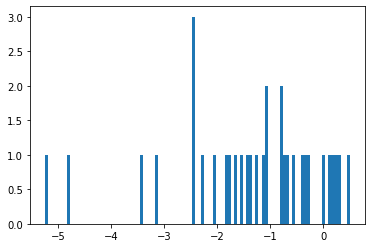

In [195]:
m = 'Offset Error (mean)'
_=plt.hist(np.array(difference_P[m])[np.abs(np.array(difference_P[m])) < 500],bins=100)

In [203]:
wave = 'T'

In [204]:
m = 'Precision'
threshold = 10

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

-0.7199999999999989
1.0326809457527746


In [205]:
m = 'Recall'
threshold = 10

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

0.04000000000000625
0.2501606462735192


In [206]:
m = 'F1 Score'
threshold = 5

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

-0.3100000000000023
0.5496361598117748


In [207]:
m = 'Onset Error (mean)'
threshold = 500

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

7.5600000000000005
5.939448840191531


In [208]:
m = 'Offset Error (mean)'
threshold = 500

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

-8.419999999999998
5.174024885617392


# Dice vs F1 - MULTI

In [218]:
results_P_multi_Dice   = {}
results_P_multi_F1     = {}
results_QRS_multi_Dice = {}
results_QRS_multi_F1   = {}
results_T_multi_Dice   = {}
results_T_multi_F1     = {}

for path in tqdm.tqdm(glob.glob('/home/guille/DADES/DADES/Delineator/TrainedModels/*/metrics_string.txt')):
    full_mname = os.path.split(os.path.split(path)[0])[1]
    mname = "_".join(full_mname.replace("DiceOnly","").split("_")[:-1])
    
    with open(path, 'r') as f:
        res = f.read().splitlines()
    
    if "DiceOnly" in full_mname:
        results_P_multi_Dice[mname] = {
            "Precision": float(res[41].split(':')[1][:-1]),
            "Recall": float(res[42].split(':')[1][:-1]),
            "F1 Score": float(res[43].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[45].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[45].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[46].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[46].split(':')[1][:-3].split("±")[1]),
        }

        results_QRS_multi_Dice[mname] = {
            "Precision": float(res[51].split(':')[1][:-1]),
            "Recall": float(res[52].split(':')[1][:-1]),
            "F1 Score": float(res[53].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[55].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[55].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[56].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[56].split(':')[1][:-3].split("±")[1]),
        }

        results_T_multi_Dice[mname] = {
            "Precision": float(res[61].split(':')[1][:-1]),
            "Recall": float(res[62].split(':')[1][:-1]),
            "F1 Score": float(res[63].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[65].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[65].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[66].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[66].split(':')[1][:-3].split("±")[1]),
        }
    else:
        results_P_multi_F1[mname] = {
            "Precision": float(res[41].split(':')[1][:-1]),
            "Recall": float(res[42].split(':')[1][:-1]),
            "F1 Score": float(res[43].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[45].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[45].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[46].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[46].split(':')[1][:-3].split("±")[1]),
        }

        results_QRS_multi_F1[mname] = {
            "Precision": float(res[51].split(':')[1][:-1]),
            "Recall": float(res[52].split(':')[1][:-1]),
            "F1 Score": float(res[53].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[55].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[55].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[56].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[56].split(':')[1][:-3].split("±")[1]),
        }

        results_T_multi_F1[mname] = {
            "Precision": float(res[61].split(':')[1][:-1]),
            "Recall": float(res[62].split(':')[1][:-1]),
            "F1 Score": float(res[63].split(':')[1][:-1]),
            "Onset Error (mean)": float(res[65].split(':')[1][:-3].split("±")[0]),
            "Onset Error (std)": float(res[65].split(':')[1][:-3].split("±")[1]),
            "Offset Error (mean)": float(res[66].split(':')[1][:-3].split("±")[0]),
            "Offset Error (std)": float(res[66].split(':')[1][:-3].split("±")[1]),
        }

results_P_multi_Dice = pd.DataFrame(results_P_multi_Dice).T
results_P_multi_F1   = pd.DataFrame(results_P_multi_F1).T
results_QRS_multi_Dice = pd.DataFrame(results_QRS_multi_Dice).T
results_QRS_multi_F1   = pd.DataFrame(results_QRS_multi_F1).T
results_T_multi_Dice = pd.DataFrame(results_T_multi_Dice).T
results_T_multi_F1   = pd.DataFrame(results_T_multi_F1).T


100%|██████████| 66/66 [00:00<00:00, 6965.88it/s]


In [219]:
difference_P = {
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "Onset Error (mean)": [],
    "Onset Error (std)": [],
    "Offset Error (mean)": [],
    "Offset Error (std)": [],
}
difference_QRS = {k: [] for k in difference_P}
difference_T   = {k: [] for k in difference_P}

for k in results_P_multi_Dice.T:
    difference_P['Precision'].append(results_P_multi_Dice["Precision"][k]-results_P_multi_F1["Precision"][k])
    difference_P['Recall'].append(results_P_multi_Dice["Recall"][k]-results_P_multi_F1["Recall"][k])
    difference_P['F1 Score'].append(results_P_multi_Dice["F1 Score"][k]-results_P_multi_F1["F1 Score"][k])
    difference_P['Onset Error (mean)'].append(results_P_multi_Dice["Onset Error (mean)"][k]-results_P_multi_F1["Onset Error (mean)"][k])
    difference_P['Onset Error (std)'].append(results_P_multi_Dice["Onset Error (std)"][k]-results_P_multi_F1["Onset Error (std)"][k])
    difference_P['Offset Error (mean)'].append(results_P_multi_Dice["Offset Error (mean)"][k]-results_P_multi_F1["Offset Error (mean)"][k])
    difference_P['Offset Error (std)'].append(results_P_multi_Dice["Offset Error (std)"][k]-results_P_multi_F1["Offset Error (std)"][k])

    difference_QRS['Precision'].append(results_QRS_multi_Dice["Precision"][k]-results_QRS_multi_F1["Precision"][k])
    difference_QRS['Recall'].append(results_QRS_multi_Dice["Recall"][k]-results_QRS_multi_F1["Recall"][k])
    difference_QRS['F1 Score'].append(results_QRS_multi_Dice["F1 Score"][k]-results_QRS_multi_F1["F1 Score"][k])
    difference_QRS['Onset Error (mean)'].append(results_QRS_multi_Dice["Onset Error (mean)"][k]-results_QRS_multi_F1["Onset Error (mean)"][k])
    difference_QRS['Onset Error (std)'].append(results_QRS_multi_Dice["Onset Error (std)"][k]-results_QRS_multi_F1["Onset Error (std)"][k])
    difference_QRS['Offset Error (mean)'].append(results_QRS_multi_Dice["Offset Error (mean)"][k]-results_QRS_multi_F1["Offset Error (mean)"][k])
    difference_QRS['Offset Error (std)'].append(results_QRS_multi_Dice["Offset Error (std)"][k]-results_QRS_multi_F1["Offset Error (std)"][k])

    difference_T['Precision'].append(results_T_multi_Dice["Precision"][k]-results_T_multi_F1["Precision"][k])
    difference_T['Recall'].append(results_T_multi_Dice["Recall"][k]-results_T_multi_F1["Recall"][k])
    difference_T['F1 Score'].append(results_T_multi_Dice["F1 Score"][k]-results_T_multi_F1["F1 Score"][k])
    difference_T['Onset Error (mean)'].append(results_T_multi_Dice["Onset Error (mean)"][k]-results_T_multi_F1["Onset Error (mean)"][k])
    difference_T['Onset Error (std)'].append(results_T_multi_Dice["Onset Error (std)"][k]-results_T_multi_F1["Onset Error (std)"][k])
    difference_T['Offset Error (mean)'].append(results_T_multi_Dice["Offset Error (mean)"][k]-results_T_multi_F1["Offset Error (mean)"][k])
    difference_T['Offset Error (std)'].append(results_T_multi_Dice["Offset Error (std)"][k]-results_T_multi_F1["Offset Error (std)"][k])


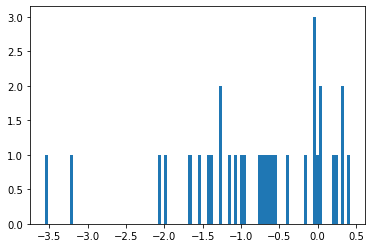

In [220]:
m = 'Offset Error (mean)'
_=plt.hist(np.array(difference_P[m])[np.abs(np.array(difference_P[m])) < 500],bins=100)

In [233]:
wave = 'QRS'

In [234]:
m = 'Precision'
threshold = 10

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

0.0
0.3936292485418493


In [235]:
m = 'Recall'
threshold = 10

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

-0.030000000000001137
0.03567015507772652


In [236]:
m = 'F1 Score'
threshold = 5

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

-0.020000000000010232
0.2072040467463481


In [237]:
m = 'Onset Error (mean)'
threshold = 500

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

0.54
0.5718246856112283


In [238]:
m = 'Offset Error (mean)'
threshold = 500

diff = np.array(eval(f"difference_{wave}")[m])
print(np.median(diff[np.abs(diff) < threshold]))
print(np.std(diff[np.abs(diff) < threshold]))

-0.5899999999999999
0.5295957187745692


In [125]:
list(zip(list(range(len(tmp))),tmp))

[(0, ''),
 (1, '# WNet5LevelsConvDiceOnly_20201130125349'),
 (2, ''),
 (3, '--- SINGLE ---'),
 (4, ''),
 (5, '######### P wave #########'),
 (6, ''),
 (7, 'Precision:    99.0%'),
 (8, 'Recall:       94.34%'),
 (9, 'F1 score:     96.62%'),
 (10, ''),
 (11, 'Onset Error:  -6.04 ± 22.67 ms'),
 (12, 'Offset Error: -2.29 ± 17.41 ms'),
 (13, ''),
 (14, ''),
 (15, '######### QRS wave #########'),
 (16, ''),
 (17, 'Precision:    99.6%'),
 (18, 'Recall:       99.9%'),
 (19, 'F1 score:     99.75%'),
 (20, ''),
 (21, 'Onset Error:  -1.98 ± 12.0 ms'),
 (22, 'Offset Error: 5.51 ± 14.93 ms'),
 (23, ''),
 (24, ''),
 (25, '######### T wave #########'),
 (26, ''),
 (27, 'Precision:    98.05%'),
 (28, 'Recall:       99.39%'),
 (29, 'F1 score:     98.71%'),
 (30, ''),
 (31, 'Onset Error:  19.4 ± 46.95 ms'),
 (32, 'Offset Error: 0.96 ± 62.74 ms'),
 (33, ''),
 (34, ''),
 (35, '---'),
 (36, ''),
 (37, '--- MULTI ---'),
 (38, ''),
 (39, '######### P wave #########'),
 (40, ''),
 (41, 'Precision:    98.56%'),